In [1]:
import os
import re
import pickle

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../scripts')
from utils import predict, predict_multi_line_text, load_data

sys.path.append('../')
from config import entity_to_acronyms, acronyms_to_entities

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


In [3]:
# from importlib import reload

# import utils
# reload(utils)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [20]:
data_dir = '../data'
model_dir = '../models'

In [7]:
(train_sequences_padded, train_labels), (val_sequences_padded, val_labels), (test_sequences_padded, test_labels), label_to_index, index_to_label = load_data(data_dir)

In [8]:
if train_sequences_padded.shape[1] != train_labels.shape[1]:
    print('Sequence length mismatch')

In [9]:
# Load the tokenizer from file
with open('../data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [10]:
INPUT_DIM = len(tokenizer.word_index)+1
EMBEDDING_DIM = 216
NUM_CLASSES = len(label_to_index)
MAX_LENGTH = train_sequences_padded.shape[1]
LSTM_UNITS = 64
DROPOUT = 0.2
BATCH_SIZE = 32
EPOCHS = 20

## Building Model

In [13]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_positives / (predicted_positives + K.epsilon())
    return _precision

def recall(y_true, y_pred):
    """Compute recall metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    """Compute f1-score metric"""
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    f1_score = 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))
    return f1_score

In [14]:
# Define the model architecture
model = tf.keras.models.Sequential([
    Embedding(INPUT_DIM, EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True)),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 216)          1505304   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         143872    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100, 79)           10191     
                                                                 
Total params: 1,659,367
Trainable params: 1,659,367
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train the model
history = model.fit(
    train_sequences_padded, 
    train_labels, 
    epochs=EPOCHS, 
    validation_data=(val_sequences_padded, val_labels)
)

Epoch 1/20


2023-04-09 11:17:46.056238: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


95/95 [==============================] - 24s 221ms/step - loss: 0.9078 - accuracy: 0.8874 - precision: 0.8346 - recall: 0.7405 - f1_score: 0.7834 - val_loss: 0.3780 - val_accuracy: 0.9129 - val_precision: 0.9896 - val_recall: 0.8872 - val_f1_score: 0.9356
Epoch 2/20
95/95 [==============================] - 15s 163ms/step - loss: 0.3853 - accuracy: 0.9065 - precision: 0.9963 - recall: 0.8789 - f1_score: 0.9339 - val_loss: 0.3665 - val_accuracy: 0.9129 - val_precision: 0.9868 - val_recall: 0.8928 - val_f1_score: 0.9374
Epoch 3/20
95/95 [==============================] - 17s 181ms/step - loss: 0.3640 - accuracy: 0.9080 - precision: 0.9961 - recall: 0.8872 - f1_score: 0.9384 - val_loss: 0.3618 - val_accuracy: 0.9150 - val_precision: 0.9840 - val_recall: 0.8985 - val_f1_score: 0.9393
Epoch 4/20
95/95 [==============================] - 14s 152ms/step - loss: 0.3408 - accuracy: 0.9136 - precision: 0.9955 - recall: 0.8945 - f1_score: 0.9422 - val_loss: 0.3536 - val_accuracy: 0.9179 - val_preci

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(['train', 'val'], loc='best')
    
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['train', 'val'], loc='best')
    
    axs[1, 0].plot(history.history['recall'])
    axs[1, 0].plot(history.history['val_recall'])
    axs[1, 0].set_title('Model Recall')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['train', 'val'], loc='best')
    
    axs[1, 1].plot(history.history['f1_score'])
    axs[1, 1].plot(history.history['val_f1_score'])
    axs[1, 1].set_title('Model F1 Score')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].legend(['train', 'val'], loc='best')
    
    plt.tight_layout()
    plt.show()


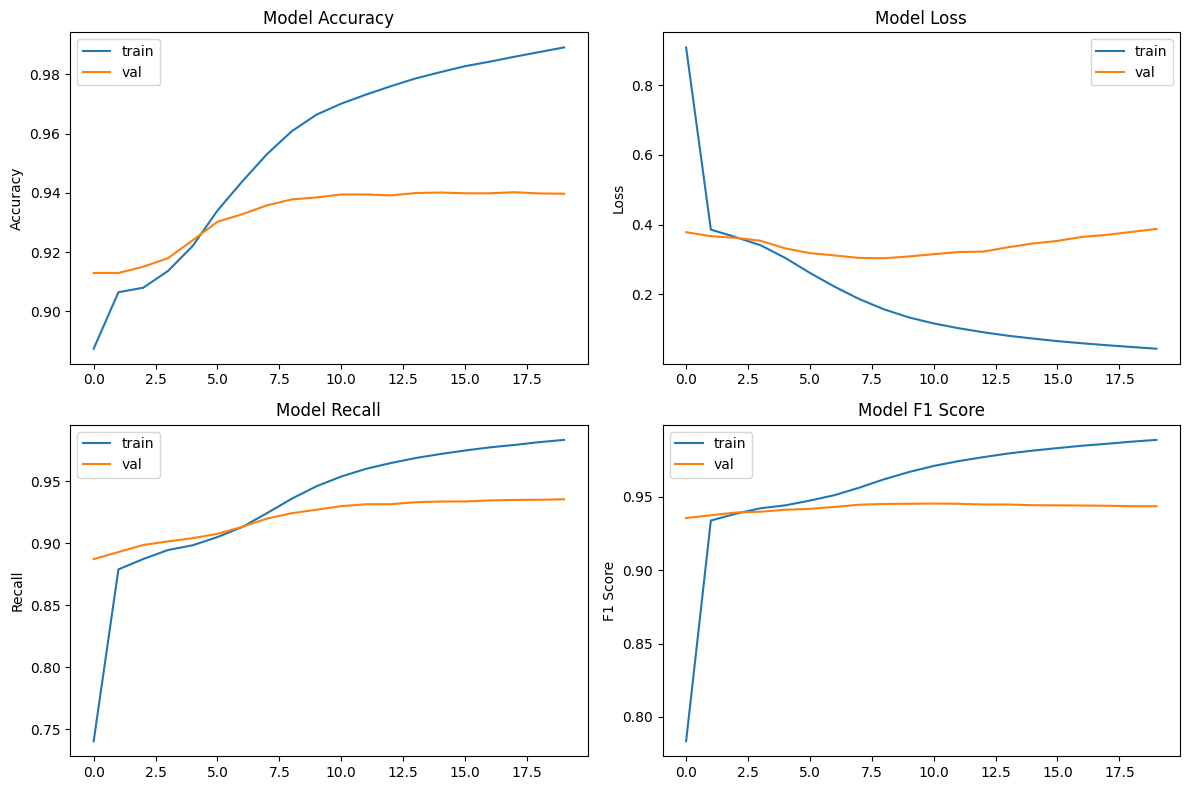

In [17]:
# Plot the training history
plot_graphs(history)

In [18]:
from sklearn.metrics import classification_report

# Get the model predictions
y_pred = model.predict(test_sequences_padded)

# Convert the predictions from one-hot encoded format to the label format
y_pred_labels = np.argmax(y_pred, axis=2)
test_labels_labels = np.argmax(test_labels, axis=2)

# Print the classification report
print(classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0))


28/28 [==============================] - 2s 40ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.51      0.49      0.50        37
           3       0.76      0.86      0.81        36
           4       0.00      0.00      0.00         4
           6       0.45      0.46      0.46       467
           7       0.66      0.63      0.64       100
           8       1.00      0.12      0.22        16
           9       0.50      0.14      0.22        56
          10       0.44      0.49      0.46        97
          11       0.31      0.24      0.27       478
          12       0.52      0.51      0.52       684
          13       0.38      0.26      0.31       236
          14       0.47      0.31      0.37        65
          15       0.32      0.29      0.30        45
          16       0.00      0.00      0.00        16
          17       0.60      0.27      0.37        11
          19       0.22    

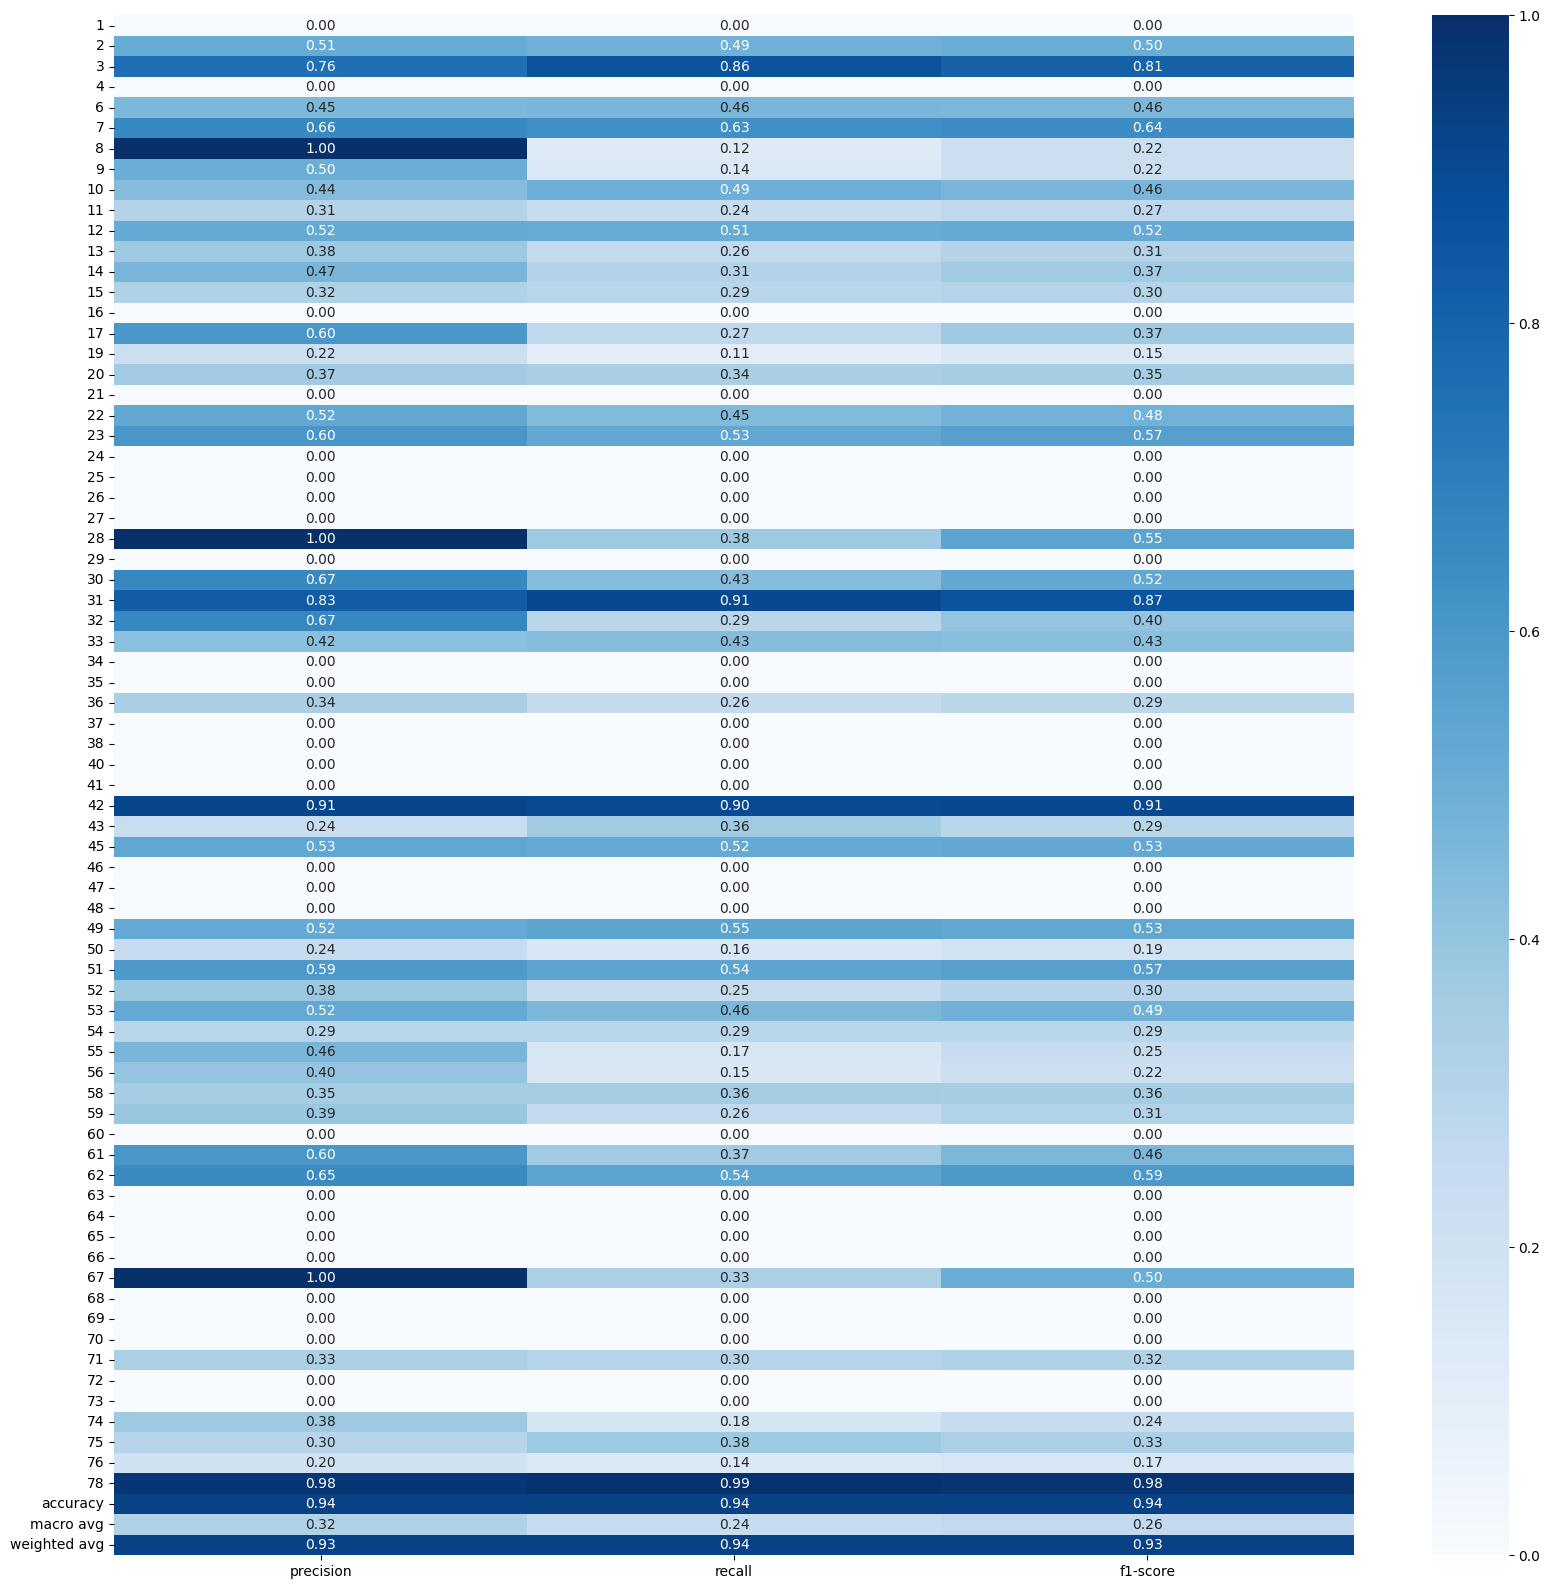

In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0, output_dict=True)
plt.subplots(figsize=(20, 20))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.show()


In the case of NER task, all three metrics - precision, recall, and F1 score - are important.

* Precision measures the proportion of predicted entities that are actually correct. In NER, precision means how many of the predicted named entities are actually true named entities.

* Recall measures the proportion of actual entities that are correctly identified by the model. In NER, recall means how many true named entities are correctly identified by the model.

* F1 score is the harmonic mean of precision and recall. It is a balanced metric that takes into account both precision and recall. F1 score is commonly used in NER evaluation as it takes into account both false positives and false negatives.

A high precision score means that the model is making very few false predictions, while a high recall score means that the model is identifying a high proportion of the true named entities. A high F1 score indicates that the model is both precise and recallful.

In [16]:
# def clean_word(word):
    
#     # remove non-alphanumeric characters and extra whitespaces
#     word = re.sub(r'[^\w\s]','',word)
#     word = re.sub(r'\s+',' ',word)
    
#     # convert to lowercase
#     word = word.lower()
    
#     if word not in STOP_WORDS:
#         return word
    
#     return ''

# def tokenize_text(text):
#     # Tokenize the text into a list of words
#     tokens = []
#     for sentence in text.split('\n'):
#         for word in sentence.split():
#             word = clean_word(word)
#             if word.strip():
#                 tokens.append(word)
#     return tokens

# def predict(text):
    
#     sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)
#     sent_tokens = []
#     sequences = []
#     for sentence in sentences:
#         tokens = tokenize_text(sentence)
#         sequence = tokenizer.texts_to_sequences([' '.join(token for token in tokens)])
#         sequences.append(sequence[0])
#         sent_tokens.append(tokens)
        
#     padded_sequence = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

#     # tokens = re.findall(r'\b\w+\b', text)
# #     tokens = tokenize_text(text)
# #     sequence = tokenizer.texts_to_sequences([' '.join(token for token in tokens)])
# #     padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')

#     # Make the prediction
#     prediction = model.predict(np.array(padded_sequence))

#     # Decode the prediction
#     predicted_labels = np.argmax(prediction, axis=-1)

#     predicted_labels = [[
#         index_to_label[i] for i in sent_predicted_labels]for sent_predicted_labels in predicted_labels]

# #     # Print the predicted named entities
#     print("Predicted Named Entities:")
#     for i in range(len(sent_tokens)):
#         for j in range(len(sent_tokens[i])):
#             if predicted_labels[i][j] == 'O':
#                 print(f"{sent_tokens[i][j]}: {predicted_labels[i][j]}")
#             else:
#                 print(f"{sent_tokens[i][j]}: {acronyms_to_entities[ predicted_labels[i][j][2:]]}")
#         print("\n\n\n")

## Save the model as an .h5 file

In [21]:
model.save(os.path.join(model_dir, 'model_1.h5'))

## Load the model 

In [25]:
# Register the custom metric function
tf.keras.utils.get_custom_objects()[precision.__name__] = precision
tf.keras.utils.get_custom_objects()[recall.__name__] = recall
tf.keras.utils.get_custom_objects()[f1_score.__name__] = f1_score

In [26]:
model_1 = tf.keras.models.load_model(os.path.join(model_dir, 'model_1.h5'))

In [27]:
predict(
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model_1, 
    tokenizer, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
)

1/1 [==============================] - 0s 328ms/step
Predicted Named Entities:
57: Age
year: Age
old: Age
man: Sex
presented: Nonbiological_location
emergency: Nonbiological_location
department: Duration
2: Duration
day: O
history: Sign_symptom
worsening: Sign_symptom
shortness: Biological_structure
breath: Sign_symptom
chest: History
pain: History
reported: History
recent: History
travel: History
sick: History
contacts: History
medical: History
history: History
significant: History
hypertension: History
dyslipidemia: History
type: History
2: Sign_symptom
diabetes: History
mellitus: Diagnostic_procedure
examination: O
tachycardic: Detailed_description
tachypneic: Detailed_description
oxygen: Biological_structure
saturation: Diagnostic_procedure
88: Detailed_description
room: O
air: Distance
chest: Distance
radiography: O
revealed: Distance
bilateral: O
opacities: O
consistent: O
pulmonary: Detailed_description
edema: Distance
patient: Distance
admitted: Distance
intensive: Medication
c

In [28]:
predict_multi_line_text(
    
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model_1, 
    tokenizer, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
    
)

1/1 [==============================] - 0s 15ms/step
Predicted Named Entities:
57: Age
year: Age
old: Age
man: Sex
presented: Nonbiological_location
emergency: Nonbiological_location
department: Duration
2: Duration
day: O
history: Sign_symptom
worsening: Sign_symptom
shortness: Biological_structure
breath: Sign_symptom
chest: O
pain: O




reported: O
recent: History
travel: History
sick: O
contacts: O




medical: O
history: O
significant: History
hypertension: History
dyslipidemia: History
type: History
2: History
diabetes: History
mellitus: History




examination: Diagnostic_procedure
tachycardic: Sign_symptom
tachypneic: Diagnostic_procedure
oxygen: Diagnostic_procedure
saturation: O
88: Detailed_description
room: Detailed_description
air: O




chest: Biological_structure
radiography: Diagnostic_procedure
revealed: Detailed_description
bilateral: O
opacities: Distance
consistent: Distance
pulmonary: O
edema: O




patient: O
admitted: Biological_structure
intensive: Nonbiological